# Understanding PolSpice

## Goal
The goal of this notebook is to recover full sky angular power spectra using the Polspice method as described in Camphius et al. (2204.13721) and Chon et al. (0303414). In order to do so, we will assume that we have observed a spin-2 complex field covering about 75% of the sky and measured its partial sky angular power spectra for the different fields ($\tilde{C}_\ell^{TT}$, $\tilde{C}_\ell^{EE}$ and $\tilde{C}_\ell;^{BB}$). We will also validate the reconstruction using full-sky theory predictions.




## Dependencies

In [1]:
!pip install healpy
!pip install camb==1.5.8

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import heracles
import numpy as np
import healpy as hp
import camb
import camb.correlations
from camb.correlations import gauss_legendre_correlation as glc

## Make data

We will use a Gaussian simulation to generate the map and then apply a square mask to it. The final masked map covers ~10% of the sky.

In [3]:
nside = 2048
lmax = 2500
bin_num = 20

In [4]:
pars = camb.CAMBparams()
pars.set_cosmology(H0=67., omch2=0.270*0.67**2, ombh2=0.049*0.67**2)
pars.InitPower.set_params(As=2.1e-9, ns=0.96)
pars.Want_CMB = False
pars.NonLinear = camb.model.NonLinear_both
pars.set_for_lmax(2*lmax, lens_potential_accuracy=1);

In [5]:
z = np.linspace(0, 3, 300)
nz = np.exp(-((0.3-z)/0.1)**2)
bz = 0.83070341 + 1.19054721*z - 0.92835749*z**2 + 0.42329232*z**3
sources = []
sources += [
    camb.sources.SplinedSourceWindow(source_type='counts', z=z, W=nz, bias_z=bz),
    camb.sources.SplinedSourceWindow(source_type='lensing', z=z, W=nz)]
pars.SourceWindows = sources

In [6]:
results = camb.get_results(pars)
camb_cls = results.get_source_cls_dict(lmax=lmax, raw_cl=True)

l = np.arange(lmax+1)
fl = -np.sqrt((l+2)*(l+1)*l*(l-1))
fl /= np.clip(l*(l+1), 1, None)

In [7]:
theory_cls = {}
theory_cls['BB'] = np.zeros(lmax+1)
theory_cls['EB'] = np.zeros(lmax+1)
theory_cls['EE'] = camb_cls['W2xW2'] * fl**2
theory_cls['TE'] = camb_cls['W2xW1'] * fl
theory_cls['TT'] = camb_cls['W1xW1']

:

In [8]:
theory_map = hp.sphtfunc.synfast([
        theory_cls['TT'],
        theory_cls['EE'],
        theory_cls['BB'] ,
        theory_cls['TE']],
        nside, new=True)

### Make Mask

In [9]:
mask = np.ones_like(theory_map[1])
pixel_theta, pixel_phi = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))
mask_type = 'Patch'

if mask_type == 'Patch':
    mask[np.pi/3 > pixel_theta] = 0.0
    mask[pixel_theta > 2*np.pi/3] = 0.0
    mask[pixel_phi > np.pi/2] = 0.0
    mask[np.pi/8> pixel_phi] = 0.0

if mask_type == 'One third cover':
    mask[np.pi/3 > pixel_theta] = 0.0

if mask_type == 'Half cover':
        mask[np.pi/2 > pixel_theta] = 0.0

if mask_type == 'Two thirds cover':
        mask[2*np.pi/3 > pixel_theta] = 0.0

if mask_type == 'None':
    mask = np.ones_like(theory_map[1])

maps = {
    'T': theory_map[0]*mask,
    'Q': theory_map[1]*mask,
    'U': theory_map[2]*mask
}

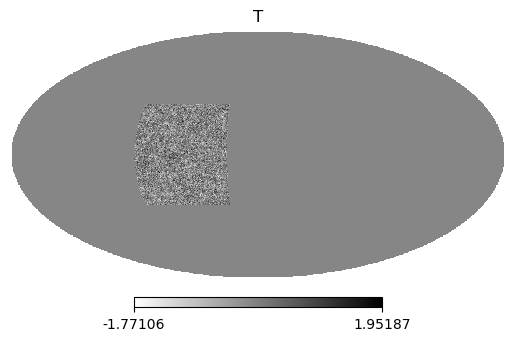

In [10]:
hp.mollview(maps['T'], cmap='binary', title='T', hold=True)

### Make Cls

In [11]:
mask_cls = hp.anafast(mask, lmax=lmax)

In [12]:
data_cls_list = hp.anafast([maps['T'], maps['Q'], maps['U']], lmax=lmax)

In [13]:
data_cls = {
    'TT': data_cls_list[0],
    'EE': data_cls_list[1],
    'BB': data_cls_list[2],
    'TE': data_cls_list[3],
    'EB': data_cls_list[4],
}

### Binning

In [14]:
def bin2pt(arr, bins, name):
    """Compute binned two-point data."""

    def norm(a, b):
        """divide a by b if a is nonzero"""
        out = np.zeros(np.broadcast(a, b).shape)
        return np.divide(a, b, where=(a != 0), out=out)

    # flatten list of bins
    bins = np.reshape(bins, -1)
    m = bins.size

    # shape of the data
    n, *ds = np.shape(arr)
    ell = np.arange(n)

    # create the structured output array
    # if input data is multi-dimensional, then so will the `name` column be
    binned = np.empty(m - 1, [(name, float, ds) if ds else (name, float)])

    # get the bin index for each ell
    i = np.digitize(ell, bins)
    assert i.size == ell.size
    wb = np.bincount(i, minlength=m)[1:m]
    # bin data in ell
    for j in np.ndindex(*ds):
        x = (slice(None), *j)
        binned[name][x] = norm(np.bincount(i, arr[x], m)[1:m], wb)

    # all done
    return binned

In [15]:
bin_edges = np.logspace(np.log10(10), np.log10(lmax+1), bin_num+1)
B = np.diag(np.ones(lmax+1))
B = bin2pt(B, bin_edges, 'B')
B = B['B']

# Binned ls
q = B @ l

### Plotting

In [16]:
fields_a = fields_b = ['T', 'E', 'B']

TT
EE
BB


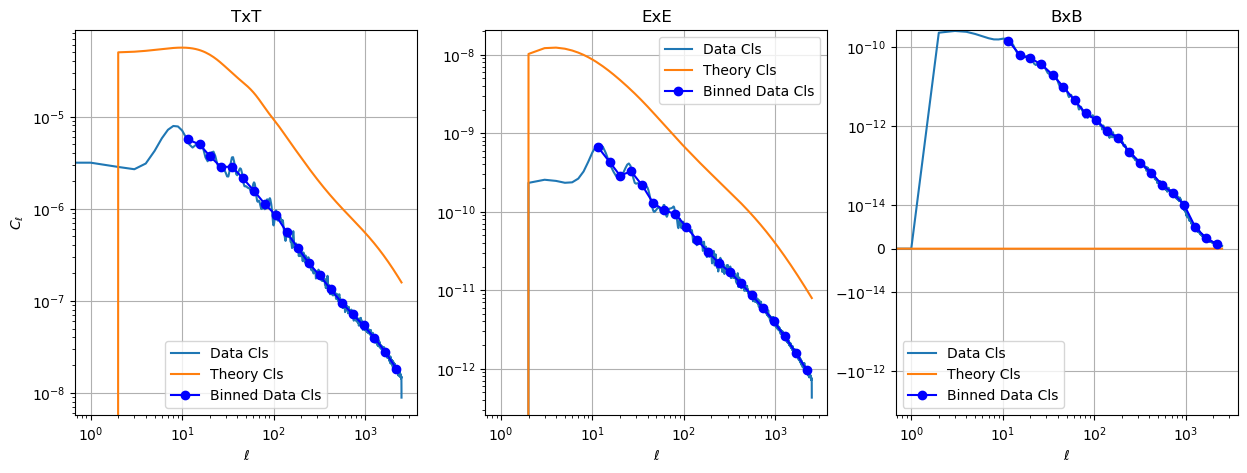

In [17]:
figure, axis = plt.subplots(1, 3, figsize=(5*3, 5))
for i, s1 in enumerate(fields_a):
    proposed_key = '{}{}'.format(s1, s1)
    print(proposed_key)
    t = theory_cls[proposed_key]
    d = data_cls[proposed_key]

    axis[i].plot(l, d, label="Data Cls")
    axis[i].plot(l, t, label="Theory Cls")
    axis[i].plot(q, B @ d, "bo-", label="Binned Data Cls")
    axis[i].set_xscale('log')
    if s1 == 'B':
        axis[i].set_yscale('symlog', linthresh=1e-14)
    else:
        axis[i].set_yscale('log')
    axis[i].set_title(f"{s1}x{s1}")
    axis[i].set_xlabel(r"$\ell$")
    if i == 0:
        axis[i].set_ylabel(r"$C_\ell$")
    axis[i].grid()
    axis[i].legend()
plt.show()

## Polspice

### Definitions
In the Polspice method we account for the effect of the mask in real space.
Let's start laying down some definitions. Given  a spin-2 complex field,
$$ \gamma(n) = (Q \pm i U)(n) \, ,$$
we can expand it in terms of the spherical harmonics in $E$ and $B$ modes:
$$ \gamma(n)  = \sum_{l m} (E_{l m} \mp i B_{l m}) _{\mp 2} Y_{l m}(n)  \, .$$


Then, we can define the correlators of the field as:
$$ \xi_{+} = \langle \gamma^* \gamma\rangle  \hspace{6pt}\rm{and}\hspace{6pt} \xi_{-} = \langle \gamma \gamma \rangle $$
In the presence of a mask, $w(\theta)$, the partial sky correlatiors are given by:
$$ \tilde{\xi}_{\pm}(\theta) = \xi_{\pm}(\theta) \xi^{ww'}(\theta) $$
where $\xi^{ww'}(\theta)$ is the mask correlation function.

Moreover, we can express these partial sky correlation functions in terms of linear combinations of the measured $E$ and $B$ angular power spectra:
$$  \tilde{\xi}_{\pm}(\theta) = \sum_l \frac{2l+1}{4\pi}(\tilde{C}^{EE}_l \pm  \tilde{C}^{BB}_l) d^l_{2 \pm 2}(\theta) \, , $$
where $d^l_{2 \pm 2}(\theta)$ are the Wigner matrices.

### Method

Our objective is to recover the full sky angular power spectra. For spin-0 fields this is as simple as transforming the measured partial sky power spectra to real space and dividing the resulting correlation function by the correlation function of mask. However, for spin-2 fields, the mask introduces a coupling between the $E$ and $B$ modes which needs to be undone.

The PolSpice method undoes the $E-B$ coupling by defining a series of correlation functions: 
$$  \tilde{\xi}_{\pm}(\theta) = \sum_l \frac{2l+1}{4\pi}(\tilde{C}^{EE}_l \pm  \tilde{C}^{BB}_l) d^l_{2 \pm 2}(\theta) \, , $$
similar to the original correlation functions but with the inverse spin-2 Wigner matrices.

One can then relate the previous correlation functions to the original correlation functions:
$$ \tilde{\xi}_{\rm{dec} \, +}(\theta) = \int^1_{-1} d\cos{\theta'} \tilde{\xi}_{+}(\theta') G(\theta', \theta) $$
and 
$$ \tilde{\xi}_{\rm{dec} \, -}(\theta) = \int^1_{-1} d\cos{\theta'} \tilde{\xi}_{-}(\theta') G(\theta, \theta') $$
where 
$$ G(\theta, \theta') = \sum_l \frac{2l+1}{2} d_{22}^\ell(\theta) d^\ell_{2-2}(\theta') $$


Now, we want to write $G$ explicitly in terms of $x = \cos{\theta}$. In order to do so, we need to leverage the orthogonality and recursive properties of the Wigner matrices. Following Varshalovich, one can write the following recursive relationship:
$$
d_{2-2}^\ell(x) =  d_{22}^\ell(x) - \frac{8(2+x)}{(1-x)^2} \int_{x}^1 \frac{1-x'}{(1+x')^2} d_{22}^\ell(x') dx' + \\
+ \frac{8}{1-x} \int^1_x \frac{1}{(1+x')^2} d^\ell_{22}(x')dx'\, .
$$
Thus, enforcing the orthogonality relation,
$$
\sum_l \frac{2l+1}{2} d_{22}^\ell(x) d^\ell_{2 2}(x') = \delta(x-x') \, ,
$$
one arrives at the following expression:
$$
G(x, x') = \delta(x'-x) \, + \\
 \rm{H}(x'-x)\left(\frac{8}{(1-x)(1+x')^2} - \frac{8(2+x)(1-x')}{(1-x)^2(1+x')^2} \right) \, ,
$$
where $\rm{H(x-x')}$ is the Heaviside function. Note that $G(x, x')$ is the curved sky equivalent of the $G(\theta, \vartheta)$ derived in 10.1051. Indeed, the 10.1051 expression can be derived from the one above by Taylor expanding around a small angle. 

Hence, we can now perform the outer integral in the previous expressions using $G$ as the kernel of integration. Moreover, we can relate the partial sky correlations to the partial sky correlation functions we derive from the measured angular power spectra, giving us:
$$
\xi_{\rm dec\, +}(x) = \xi_{+}(x) - \frac{8(2+x)}{(1-x)^2} \int_x^1 \frac{1-x'}{(1+x')^2} \frac{\tilde{\xi}_{+}(x')}{\xi^{ww'}(x)}  dx' + \\ 
+ \frac{8}{1-x} \int^1_x \frac{1}{(1+x')^2} \frac{\tilde{\xi}_{+}(x')}{\xi^{ww'}(x)} dx' \, ,
$$
and
$$
\xi_{\rm{dec} \, -}(x) = \xi_{-}(x) - \frac{8(2-x)}{(1+x)^2} \int_{-1}^{x}  \frac{1+x'}{(1-x')^2} \frac{\tilde{\xi}_{-}(x')}{\xi^{ww}(x)} dx' +  \\
+ \frac{8}{1+x} \int_{-1}^{x} \frac{1}{(1-x')^2} \frac{\tilde{\xi}_{-}(x')}{\xi^{ww}(x)} dx' \, .
$$

One can then combine the previous expressions to build estimators for pure E- and B-mode correlation functions as:
$$
    \xi^{EE}_\pm = \frac{1}{2}\left(\xi_{\rm{dec}\, \pm} + \xi_\mp\right) \, ,
$$
and
$$
    \xi^{BB}_\pm = \frac{\pm1}{2}\left(\xi_\pm - \xi_{{\rm dec} \mp}\right)
$$


In order to map back to angular power spectra, we have to be mindful of using the opposed spin of the Wigner matrix to undo our original choice. Thus the PolSpice estimator for the full-sky angular power spectra reads:
$$
    C_{\ell \, \pm}^{EE} = \pi \int^1_{-1} {\rm d}x \left[ \xi_{\rm{dec} \, \pm }(x) + \xi_{\mp}(x) \right] d^l{2\mp2}(x)
$$
and
$$
    C_{\ell \, \pm}^{BB} = \pi \int^1_{-1} {\rm d}x \pm \left[ \xi_{\rm{dec} \, \pm }(x) - \xi_{\mp}(x) \right] d^l{2\mp2}(x)
$$

In [18]:
def logistic(x, x0=-2, k=50):
    return 1.0 + np.exp(-k * (x - x0))

In [19]:
from scipy.interpolate import interp1d
from scipy.integrate import cumulative_simpson

def Eq90_plus(x, xi_p):
    theta = np.arccos(x)[::-1]
    dtheta = theta[1] - theta[0]
    prefac1 = 8 * (2 + x) / (1 - x) ** 2
    integ1 = (1 - x) / (1 + x) ** 2
    integ1 *= xi_p
    int1 = cumulative_simpson(integ1[::-1] * np.sin(theta[::-1]), dx=dtheta, initial=0)[::-1]
    t1 = prefac1 * int1
    prefac2 = 8 / (1 - x)
    integ2 = 1 / (1 + x) ** 2
    integ2 *= xi_p
    int2 = cumulative_simpson(integ2[::-1] * np.sin(theta[::-1]), dx=dtheta, initial=0)[::-1]
    t2 = prefac2 * int2
    eq90 = xi_p - t1 + t2
    return eq90

def Eq90_minus(x, xi_m):
    theta = np.arccos(x)[::-1]
    dtheta = theta[1] - theta[0]
    prefac1 = 8 * (2 - x) / (1 + x) ** 2
    integ1 = (1 + x) / (1 - x) ** 2
    integ1 *= xi_m
    int1 = cumulative_simpson(integ1 * np.sin(theta[::-1]), dx=dtheta, initial=0)
    t1 = prefac1 * int1
    prefac2 = 8 / (1 + x)
    integ2 = 1 / (1 - x) ** 2
    integ2 *= xi_m
    int2 = cumulative_simpson(integ2 * np.sin(theta[::-1]), dx=dtheta, initial=0)
    t2 = prefac2 * int2
    eq90 = xi_m - t1 + t2
    return eq90


In [20]:
# Compute the correlation function of the data
prefac = l * (l + 1) / (2 * np.pi)
cls_for_corr = np.array([
    data_cls['TT'],
    data_cls['EE'],
    data_cls['BB'],
    np.zeros(lmax+1)])
cls_for_corr *= prefac
data_corr, corr_x, corr_w = glc(cls_for_corr.T,
                                lmax=lmax,
                                sampling_factor=1)
data_corr[:, 0] += data_cls['TT'][0]/(4*np.pi)
xi_TT = data_corr.T[0]
xi_p  = data_corr.T[1]
xi_m  = data_corr.T[2]

# Compute the correlation function of the mask
mask_for_corr = np.transpose([
  mask_cls * prefac,
  np.zeros(lmax+1),
  np.zeros(lmax+1),
  np.zeros(lmax+1)])
mask_corr, mask_corr_x, mask_corr_w = glc(mask_for_corr,
                                          lmax=lmax,
                                          sampling_factor=1)
mask_corr[:, 0] += mask_cls[0]/(4*np.pi)
xi_mask = mask_corr.T[0]
xi_mask *= logistic(np.log10(abs(xi_mask)))

In [21]:
#Polspice
xi_dec_plus = Eq90_plus(corr_x, xi_p)/xi_mask
xi_dec_minus = Eq90_minus(corr_x, xi_m)/xi_mask

# Prefactor for the correlation function
prefac[0] = 1

# Transform back to Cl using dl2-2
pols_plus_corrs_1 = np.array([
    xi_TT/xi_mask,
    np.zeros(lmax+1),
    xi_dec_plus,
    np.zeros(lmax+1)])
pols_plus_1_cls_list = camb.correlations.corr2cl(pols_plus_corrs_1.T,
                                          corr_x, corr_w, lmax)
pols_plus_1_cls_list = pols_plus_1_cls_list.T/prefac

pols_plus_corrs_2 = np.array([
    xi_TT/xi_mask,
    np.zeros(lmax+1),
    xi_m/xi_mask,   #xi_BB_camb,
    np.zeros(lmax+1)])
pols_plus_2_cls_list = camb.correlations.corr2cl(pols_plus_corrs_2.T,
                                          corr_x, corr_w, lmax)
pols_plus_2_cls_list = pols_plus_2_cls_list.T/prefac

pols_plus_cls = {}
pols_plus_cls['TT'] = pols_plus_1_cls_list[0]
pols_plus_cls['EE'] = -(pols_plus_1_cls_list[2]+pols_plus_2_cls_list[2])
pols_plus_cls['BB'] = (pols_plus_1_cls_list[2]-pols_plus_2_cls_list[2])
# Transform back to Cl using dl22
pols_minus_corrs_1 = np.array([
    xi_TT/xi_mask,
    xi_p/xi_mask, 
    np.zeros(lmax+1),
    np.zeros(lmax+1)])
pols_minus_1_cls_list = camb.correlations.corr2cl(pols_minus_corrs_1.T,
                                          corr_x, corr_w, lmax)
pols_minus_1_cls_list = pols_minus_1_cls_list.T/prefac

pols_minus_corrs_2 = np.array([
    xi_TT/xi_mask,
    xi_dec_minus,
    np.zeros(lmax+1),
    np.zeros(lmax+1)])
pols_minus_2_cls_list = camb.correlations.corr2cl(pols_minus_corrs_2.T,
                                          corr_x, corr_w, lmax)
pols_minus_2_cls_list = pols_minus_2_cls_list.T/prefac

pols_minus_cls = {}
pols_minus_cls['TT'] = pols_minus_1_cls_list[0]
pols_minus_cls['EE'] = (pols_minus_1_cls_list[1]+pols_minus_2_cls_list[1])
pols_minus_cls['BB'] = (pols_minus_1_cls_list[1]-pols_minus_2_cls_list[1])

### Natural Unmxing
Alternatively, we could construct a series of estimators which exhibit mixing for both $C^{EE}_l$ and $C^{BB}_l$. In order to do so let us define the angular power spectra:
$$
C_l^{\pm} = C_l^{EE} \pm C_l^{BB} = \nonumber \\
= 2 \pi \int \frac{1}{\xi^{ww'}(\theta)} \left( \sum_l \frac{2l+1}{4\pi} (\tilde{C}_l^E \pm \tilde{C}_l^B) d^l_{2\pm2}\right) d^l_{2\pm2} {\rm d}\cos{\theta}
$$
Then the respective estimators for the uncoupled E and B fields can be obtained by considering:
$$
C_l^{EE} = \frac{1}{2}(C_l^{+} + C_l^{-}) \,, \\
C_l^{BB} = \frac{1}{2}(C_l^{+} - C_l^{-}) \,  .
$$

We will refer to this method as the "Naive PolSpice" method.

In [22]:
#Naive Polspice
prefac = l * (l + 1) / (2 * np.pi)
naive_pols_corrs = data_corr.T/xi_mask
naive_pols_cls_list = camb.correlations.corr2cl(naive_pols_corrs.T,
                                                corr_x, corr_w, lmax)
prefac[0] = 1
naive_pols_cls_list = naive_pols_cls_list.T/prefac

naive_pols_cls = {}
naive_pols_cls['TT'] = naive_pols_cls_list[0]
naive_pols_cls['EE'] = naive_pols_cls_list[1]
naive_pols_cls['BB'] = naive_pols_cls_list[2]


TT
EE
BB


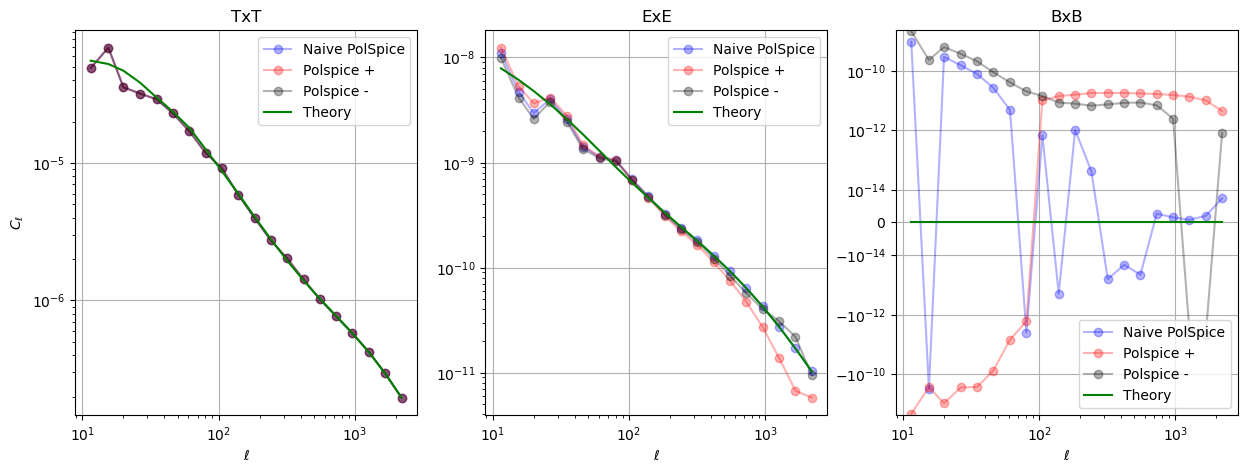

In [23]:
figure, axis = plt.subplots(1, 3, figsize=(5*3, 5))
for i, s1 in enumerate(fields_a):
    proposed_key = '{}{}'.format(s1, s1)
    print(proposed_key)
    t    = theory_cls[proposed_key]
    d_p  = naive_pols_cls[proposed_key]
    d_eq_p = pols_plus_cls[proposed_key]
    d_eq_m = pols_minus_cls[proposed_key]

    axis[i].plot(q, B @ d_p, 'bo-', alpha=0.3, label="Naive PolSpice")
    axis[i].plot(q, B @ d_eq_p, 'ro-', alpha=0.3, label="Polspice +")
    axis[i].plot(q, B @ d_eq_m, 'ko-', alpha=0.3, label="Polspice -")
    axis[i].plot(q, B @ t, 'g-', label="Theory")
    axis[i].set_xscale('log')
    if s1 == 'B':
        axis[i].set_yscale('symlog', linthresh=1e-14)
    else:
        axis[i].set_yscale('log')
    axis[i].set_title(f"{s1}x{s1}")
    axis[i].set_xlabel(r"$\ell$")
    if i == 0:
        axis[i].set_ylabel(r"$C_\ell$")
    axis[i].grid()
    axis[i].legend()
plt.show()

As we can see the Naive Polspice method matches performs similar if not better at unmixing the E and B modes than the traditional PolSpice method. Our questions is then, what's the motivation behind the PolSpice method?
Thank you so much!